In [1]:
pip install adjustText

Note: you may need to restart the kernel to use updated packages.


# LOADING DATASET

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text  

# Load data
menu = pd.read_csv('../Data/manu_FC.csv')
orders = pd.read_csv('../Data/selling_transactions.csv')
inventory = pd.read_csv('../Data/inventory_waste.csv')
recipes = pd.read_csv('../Data/recipes.csv')

# Display DF heads
print("Menu DF:")
display(menu.head())
print("Orders DF:")
display(orders.head())
print("Inventory DF:")
display(inventory.head())
print("Recipes DF:")
display(recipes.head())

Menu DF:


,item_id,item_name,category,theoretical_cost,target_margin,is_active
0,ANT-001,Bruschetta al pomodoro,Antipasti,1.8,74,True
1,ANT-002,Caprese,Antipasti,2.5,72,True
2,ANT-003,Prosciutto e melone,Antipasti,3.2,71,True
3,ANT-004,Affettati misti,Antipasti,4.0,69,True
4,PIZ-001,Margherita,Pizze,2.1,77,True


Orders DF:


,transaction_id,timestamp,store_id,item_id,channel,qty,total_net_price
0,TXN-000001,2024-01-01 20:22:00,MIL-01,PIZ-002,Glovo,2,16.0
1,TXN-000002,2024-01-01 13:52:00,MIL-01,BEV-005,Sala,2,3.0
2,TXN-000003,2024-01-01 21:54:00,MIL-01,PRI-003,Deliveroo,2,26.0
3,TXN-000004,2024-01-01 20:51:00,MIL-01,SEC-005,Take-away,2,32.0
4,TXN-000005,2024-01-01 13:02:00,MIL-01,PIZ-007,Deliveroo,1,15.0


Inventory DF:


,date,store_id,item_id,ingredient_name,waste_type,waste_qty,waste_value
0,2024-01-01,MIL-01,FAR-01,Farina tipo 00 (kg),Scaduto,0.98,0.78
1,2024-01-01,MIL-01,FAR-01,Farina tipo 00 (kg),Sfrido,1.33,1.06
2,2024-01-01,MIL-01,VER-01,Verdure miste (kg),Deteriorato,1.30,4.55
3,2024-01-01,MIL-02,PRO-01,Prosciutto crudo (kg),Errore Comanda,1.92,42.24
4,2024-01-01,MIL-02,VER-01,Verdure miste (kg),Sfrido,1.85,6.48


Recipes DF:


,dish_id,dish_name,ingredient_id,ingredient_name,quantity,unit,costo_unitario,costo_ingrediente
0,ANT-001,Bruschetta al pomodoro,TOM-01,Pomodoro pelato,0.080,kg,1.2,0.10
1,ANT-001,Bruschetta al pomodoro,OLI-01,Olio EVO,0.015,lt,5.0,0.07
2,ANT-001,Bruschetta al pomodoro,BAS-01,Basilico,0.300,mazzo,1.5,0.45
3,ANT-002,Caprese,MOZZ-01,Mozzarella fior di latte,0.125,kg,5.5,0.69
4,ANT-002,Caprese,TOM-01,Pomodoro pelato,0.150,kg,1.2,0.18


### **Dfs are quite balanced in some features, so I decided augmenting data**

In [ ]:
def inject_realism_full(sales_df, inventory_df, menu_df):
    print("---  REALISTIC SIMULATION: FULL MENU ---")
    
    # Work on copies to avoid modifying original data
    sales_df = sales_df.copy()
    inventory_df = inventory_df.copy()
    
    # --- 1. SETTING SCENARIO ---
    sales_scenario = {
        'Acqua naturale':       {'qty': 4.0, 'price': 1.0},
        'Caffè':                {'qty': 3.5, 'price': 1.0},
        'Spritz':               {'qty': 2.0, 'price': 1.2},
        'Vino rosso (calice)':  {'qty': 1.5, 'price': 1.1},
        'Birra media':          {'qty': 2.5, 'price': 1.0},
        'Margherita':           {'qty': 3.0, 'price': 1.0},
        'Diavola':              {'qty': 0.6, 'price': 1.0},
        'Marinara':             {'qty': 0.2, 'price': 1.0},
        'Pizza gourmet tartufo':{'qty': 0.4, 'price': 1.5},
        'Bufala e pachino':     {'qty': 1.2, 'price': 1.2},
        'Carbonara':            {'qty': 2.2, 'price': 1.0},
        'Amatriciana':          {'qty': 1.8, 'price': 1.0},
        'Cacio e pepe':         {'qty': 1.5, 'price': 1.1},
        'Branzino al forno':    {'qty': 0.8, 'price': 1.3},
        'Tagliata di manzo':    {'qty': 0.7, 'price': 1.4},
        'Cotoletta alla milanese': {'qty': 1.5, 'price': 1.1},
        'Tiramisù':             {'qty': 2.0, 'price': 1.0},
        'Panna cotta':          {'qty': 0.5, 'price': 1.0},
    }

    waste_scenario = {
        'Mozzarella (kg)':          3.5,
        'Pesce branzino (kg)':      4.0,
        'Verdure miste (kg)':       2.5,
        'Prosciutto crudo (kg)':    1.5,
        'Carne manzo (kg)':         1.2,
        'Salame piccante (kg)':     1.8,
        'Funghi porcini (kg)':      1.3,
        'Farina tipo 00 (kg)':      0.2,
        'Olio EVO (lt)':            0.1,
        'Pomodoro San Marzano (kg)':0.3,
    }

    # --- 2. APPLYING SALES LOGIC ---
    sales_df['unit_price_temp'] = sales_df['total_net_price'] / sales_df['qty']
    
    for item_name, multipliers in sales_scenario.items():
        try:
            target_ids = menu_df.loc[menu_df['item_name'] == item_name, 'item_id'].values
            if len(target_ids) > 0:
                t_id = target_ids[0]
                mask = sales_df['item_id'] == t_id
                
                if mask.any():
                    sales_df.loc[mask, 'qty'] *= multipliers['qty']
                    new_price = sales_df.loc[mask, 'unit_price_temp'] * multipliers['price']
                    sales_df.loc[mask, 'total_net_price'] = sales_df.loc[mask, 'qty'] * new_price
        except Exception as e:
            print(f"Skipping {item_name}: {e}")

    sales_df.drop(columns=['unit_price_temp'], inplace=True)

    # --- 3. APPLYING WASTE LOGIC ---
    # Adding random noise to waste quantities
    inventory_df['waste_qty'] *= 1.0 
    
    # setting known multipliers for specific ingredients
    known_mapping = {
        'MOZZ-01': 3.5, # Mozzarella
        'PES-01':  4.0, # Branzino
        'FAR-01':  0.2, # Farina
        'SAL-01':  1.8, # Salame
        'OLI-01':  0.1, # Olio
        'TOM-01':  0.3, # Pomodoro
        'FUN-01':  1.3  # Funghi
    }
    
    for ing_id, mult in known_mapping.items():
        col_name = 'ingredient_id' if 'ingredient_id' in inventory_df.columns else 'item_id'
        mask = inventory_df[col_name] == ing_id
        
        if mask.any():
            inventory_df.loc[mask, 'waste_qty'] *= mult
            inventory_df.loc[mask, 'waste_value'] *= mult

    print("Data correctly unbalanced!")
    
    return sales_df, inventory_df

orders, inventory = inject_realism_full(orders, inventory, menu)

--- 🌪️ AVVIO SIMULAZIONE REALISTICA: FULL MENU ---
✅ Dati sbilanciati correttamente!


/var/folders/rw/gn7kmssn2p7gjvsj5rblz4sh0000gn/T/ipykernel_42380/2840248113.py:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[7.  7.  7.  ... 7.  7.  3.5]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sales_df.loc[mask, 'qty'] *= multipliers['qty']


# FIRST PILLAR - PROFITABILITY

In [3]:
# PROFITABILITY ANALYSIS PIPELINE

# --- STEP 1:INGREDIENT ANALYSIS ---

# 1. Calculation Average and Total Unit Cost Waste per ingredient: Estimated Unit Cost = Waste Value / Waste Quantity
inventory['unit_cost_est'] = inventory['waste_value'] / inventory['waste_qty']
ing_stats = inventory.groupby('item_id').agg({
    'unit_cost_est': 'mean',    
    'waste_qty': 'sum'          
}).reset_index().rename(columns={'item_id': 'ingredient_id', 'waste_qty': 'waste_kg_total'})

# 2. Calculation Total Theoretical Consumption (How much we should have used, without considering waste)
sales_exploded = pd.merge(orders, recipes, left_on='item_id', right_on='dish_id')
sales_exploded['theo_qty'] = sales_exploded['qty'] * sales_exploded['quantity']
theo_stats = sales_exploded.groupby('ingredient_id')['theo_qty'].sum().reset_index()

# 3. Merging: Creation of the Inefficiency Factor (K)
k_df = pd.merge(theo_stats, ing_stats, on='ingredient_id', how='left').fillna(0)

# K = (Theoretical + Waste) / Theoretical
k_df['k_factor'] = np.where(k_df['theo_qty'] > 0, 
                           (k_df['theo_qty'] + k_df['waste_kg_total']) / k_df['theo_qty'], 1)
                                       
# --- STEP 2: DISH ANALYSIS ---

# 4. Applying the K-Factor to the recipe: each ingredient now costs: (Quantity * Unit Cost) * K
recipes_real = pd.merge(recipes, k_df[['ingredient_id', 'unit_cost_est', 'k_factor']], on='ingredient_id', how='left')

# Theoretical Cost (Standard) vs. Real Cost (With Waste): I first calculate the theoretical cost: how much a single dish should cost if there was no waste
recipes_real['cost_theo'] = recipes_real['quantity'] * recipes_real['unit_cost_est']
# Addiyng k_factor to get the real cost: how much that dish really costs you, plus the waste "tax".
recipes_real['cost_real'] = recipes_real['cost_theo'] * recipes_real['k_factor']

# 5. Adding all the ingredients to get the cost of the dish
dish_costs = recipes_real.groupby('dish_id').agg({
    'cost_theo': 'sum',
    'cost_real': 'sum'
}).reset_index()

# --- STEP 3: THE VERDICT ---

# 6. Average actual selling price (net of discounts): total_net_price (real money collected) divided by the dishes sold. It's the "Average Receipt Price".
avg_sales = orders.groupby('item_id').agg({'total_net_price': 'sum', 'qty': 'sum'}).reset_index()
avg_sales['real_price'] = avg_sales['total_net_price'] / avg_sales['qty']

# 7. Final Table
final_report = pd.merge(dish_costs, avg_sales[['item_id', 'real_price', 'qty']], left_on='dish_id', right_on='item_id').rename(columns={'qty': 'sold_qty'})
final_report = pd.merge(final_report, menu[['item_id', 'item_name', 'category']], on='item_id')

# Calculation Contribution Margin. This is the money you have left in your pocket to pay your rent, electricity, and salary. It is the Contribution Margin: in € and in %
final_report['margin_real_€'] = final_report['real_price'] - final_report['cost_real']
final_report['margin_pct'] = (final_report['margin_real_€'] / final_report['real_price']) * 100

# Ordering for the most critical dishes (those where we lose money or earn little)
display(final_report[['category', 'item_name', 'real_price', 'cost_theo', 'cost_real', 'sold_qty', 'margin_pct', 'margin_real_€']].sort_values('margin_real_€', ascending=False).round(2))

# 7.1. Identifing dishes that have Theoretical Cost = 0 
ghost_dishes = final_report[final_report['cost_theo'] == 0]

print(f"There are {len(ghost_dishes)} dishes without a recipe or cost:")
display(ghost_dishes[['item_name', 'sold_qty', 'real_price', 'cost_theo', 'margin_pct']])

# 7.2. filtering these plates away from the final graph so as not to distort the matrix
final_report_clean = final_report[final_report['cost_theo'] > 0].copy()

print(f"\nCleaned report: removed {len(ghost_dishes)} rows. Proceeding with analysis.")

# 8. Visualizzazione Matrice Profitabilità

,category,item_name,real_price,cost_theo,cost_real,sold_qty,margin_pct,margin_real_€
18,Pizze,Pizza gourmet tartufo,33.0,0.50,0.52,2647.6,98.44,32.48
26,Secondi,Tagliata di manzo,33.6,6.72,9.72,4587.8,71.08,23.88
28,Secondi,Cotoletta alla milanese,22.0,0.00,0.00,9903.0,100.00,22.00
27,Secondi,Ossobuco alla milanese,22.0,0.58,0.71,6604.0,96.78,21.29
25,Primi,Risotto ai funghi porcini,18.0,0.00,0.00,6309.0,100.00,18.00
16,Pizze,Bufala e pachino,18.0,0.92,0.95,7742.4,94.72,17.05
30,Secondi,Pollo arrosto,16.0,0.24,0.25,6606.0,98.44,15.75
23,Primi,Spaghetti alle vongole,16.0,0.36,0.37,6341.0,97.66,15.63
24,Primi,Risotto alla milanese,15.0,0.00,0.00,6552.0,100.00,15.00
21,Primi,Cacio e pepe,14.3,0.00,0.00,9793.5,100.00,14.30


There are 8 dishes without a recipe or cost:


,item_name,sold_qty,real_price,cost_theo,margin_pct
7,Tiramisù,12674.0,7.0,0.0,100.0
8,Panna cotta,3189.0,6.0,0.0,100.0
9,Cheesecake,6450.0,8.0,0.0,100.0
19,Carbonara,14405.6,14.0,0.0,100.0
21,Cacio e pepe,9793.5,14.3,0.0,100.0
24,Risotto alla milanese,6552.0,15.0,0.0,100.0
25,Risotto ai funghi porcini,6309.0,18.0,0.0,100.0
28,Cotoletta alla milanese,9903.0,22.0,0.0,100.0



Cleaned report: removed 8 rows. Proceeding with analysis.


In [ ]:
# Noise removal and average graph values
final_report_clean_filtered = final_report_clean[~((final_report_clean['sold_qty'] > 6000) & (final_report_clean['sold_qty'] < 6700))]

/var/folders/rw/gn7kmssn2p7gjvsj5rblz4sh0000gn/T/ipykernel_42380/524356488.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['me_category'] = df.apply(get_category, axis=1)


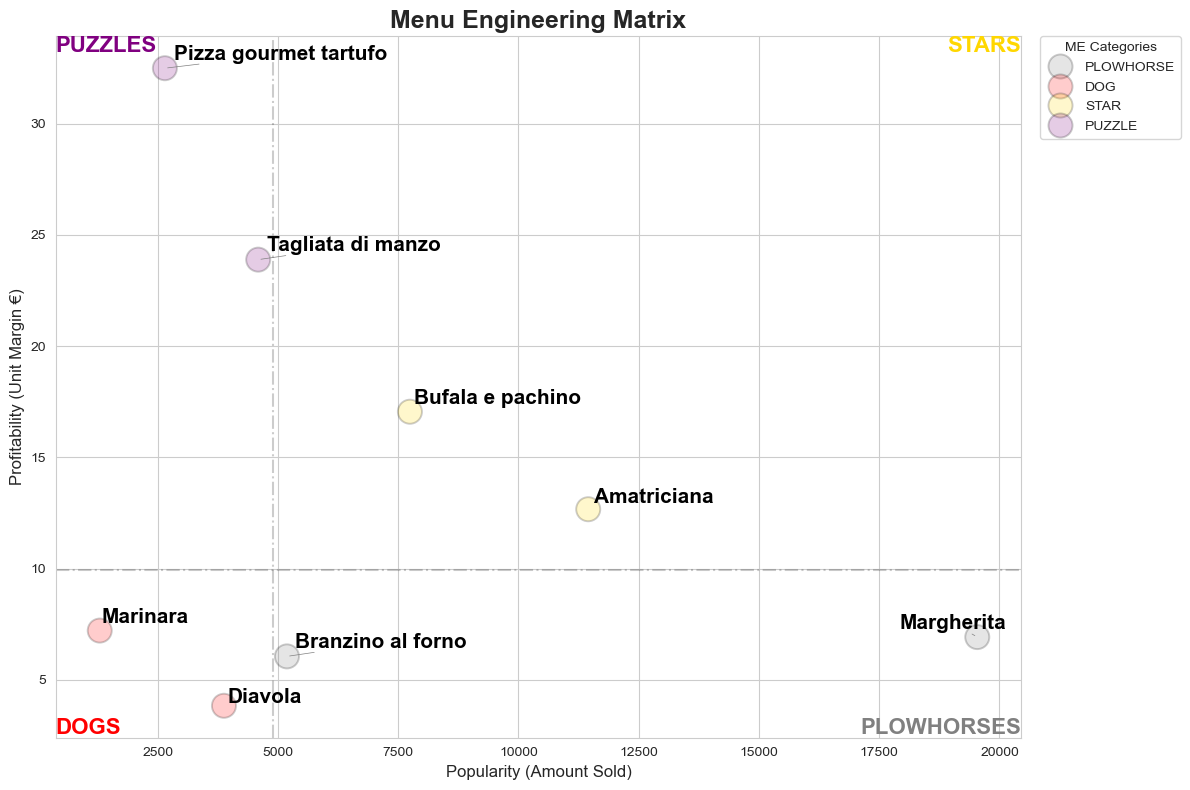

In [ ]:
# CREATING FUNCTION TO PLOT MENU ENGINEERING MATRIX 
def create_menu_matrix(df, x_col='sold_qty', y_col='margin_real_€', label_col='item_name', title="Menu Engineering Matrix"):
    """
    Generate a professional Engineering Menu matrix.
    
    Args:
        df: The dataframe containing the data.
        x_col: Column name Popularity (e.g. 'qty').
        y_col: Profitability column name (e.g. 'margin_real_€').
        label_col: Name of the column with the names of the dishes.

    Requirements:
        - matplotlib
        - seaborn
        - adjustText (optional, for better label management)
    """

    # 1. importing adjustText to handle labels
    try:
        from adjustText import adjust_text
        HAS_ADJUST_TEXT = True
    except ImportError:
        HAS_ADJUST_TEXT = False
        
    
    # 2. Calculating Medians (the boundaries of the quadrants)
    median_x = df[x_col].median()
    median_y = df[y_col].median()

    # 3. Assigning the category to each dish to color them
    def get_category(row):
        if row[x_col] >= median_x and row[y_col] >= median_y:
            return 'STAR'
        elif row[x_col] < median_x and row[y_col] >= median_y:
            return 'PUZZLE'
        elif row[x_col] >= median_x and row[y_col] < median_y:
            return 'PLOWHORSE'
        else:
            return 'DOG'

    df['me_category'] = df.apply(get_category, axis=1)
    
    # Setting color palette
    palette = {
        'STAR': 'gold',       
        'PUZZLE': 'purple',   
        'PLOWHORSE': 'gray',  
        'DOG': 'red'         
    }

    # 4. Graphic setup
    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid")
    
    # Main scatterplot 
    sns.scatterplot(
        data=df, 
        x=x_col, 
        y=y_col, 
        hue='me_category',  
        palette=palette,
        s=300,              
        edgecolor='black',
        alpha=0.2
    )

    # 5. Drwawing quadrants lines
    plt.axvline(median_x, color='black', linestyle='-.', alpha=0.2)
    plt.axhline(median_y, color='black', linestyle='-.', alpha=0.2)
    
    # List where collecting all text objects
    texts = []
    
    # Loop over each row of the dataframe
    for i in range(df.shape[0]):
        # Creating text object but we don't print it permanently yet
        t = plt.text(
            x=df[x_col].iloc[i], 
            y=df[y_col].iloc[i], 
            s=df[label_col].iloc[i],
            fontsize=15, 
            weight='bold', 
            color='black'
        )
        texts.append(t) 
    
    # Applyiing adjust text
    if HAS_ADJUST_TEXT:
        adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

    # 6. FINAL FORMATTING ---
    # Quadrant Labels
    x_lims = plt.xlim()
    y_lims = plt.ylim()
    plt.text(x_lims[1], y_lims[1], 'STARS', ha='right', va='top', fontsize=16, color='gold', weight='heavy')
    plt.text(x_lims[0], y_lims[1], 'PUZZLES', ha='left', va='top', fontsize=16, color='purple', weight='heavy')
    plt.text(x_lims[1], y_lims[0], 'PLOWHORSES', ha='right', va='bottom', fontsize=16, color='gray', weight='heavy')
    plt.text(x_lims[0], y_lims[0], 'DOGS', ha='left', va='bottom', fontsize=16, color='red', weight='heavy')

    # Titles
    plt.title(title, fontsize=18, weight='bold')
    plt.xlabel('Popularity (Amount Sold)', fontsize=12)
    plt.ylabel('Profitability (Unit Margin €)', fontsize=12)
    
    # Moving legend out the graph
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title="ME Categories")
    
    plt.tight_layout()
    plt.show()

# Plotting the Menu Engineering Matrix
create_menu_matrix(final_report_clean_filtered)